In [5]:
import firebase_admin
from firebase_admin import db
from datetime import datetime
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
cred_obj = firebase_admin.credentials.Certificate("Morphine2.json")
default_app = firebase_admin.initialize_app(cred_obj, {
  'databaseURL':'https://morphine-64cdd-default-rtdb.asia-southeast1.firebasedatabase.app/'
  })

In [21]:
ref_test1 = db.reference("/Test 1")
ref_test2 = db.reference("/Test 2")
ref_users_data = db.reference("/Users Data/Token UID:XvIeVwC7M0QN0qW15FNYO2e5BJ93")

In [15]:
# Keywords to extract for each set
keywords = ['Ax: ', 'Ay: ', 'Az: ', 'gx: ', 'gy: ', 'gz: ', 'temp: ', 'timing for this set: ']

# length of each keyword
length_keywords = [len(x) for x in keywords]

In [10]:
# create dataframe to store all the firebase readings
test1_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'aXarr', 'aYarr', 'aZarr', 'gXarr', 'gYarr', 'gZarr', 'tempArr', 'timeDifference'])

In [11]:
test2_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])

In [16]:
users_data_df = pd.DataFrame(columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])

In [13]:
# function to extract every variable for one set
def process_set(output_set):
    indexes = [output_set.find(keyword) for keyword in keywords]
    df_row = []
    curr_data_index = int(output_set[:indexes[0]].strip())
    df_row.append(curr_data_index) # append in the index of the new input
    for i, index in enumerate(indexes):
        if i == len(indexes) - 1:
            x = output_set[index+length_keywords[i]:].strip() 
            df_row.append(x)
        else:
            x = output_set[index+length_keywords[i]: indexes[i+1]].strip()
            df_row.append(x)
    return df_row

# function to extract every variables for every data (with 20 sets) read in
def test2_process_esp32_output(esp32_output, timeDifference):
    global test2_df
    accounter = esp32_output['Accounter']
    LoopSpeedArr = esp32_output['LoopSpeedArr'][0]
    UploadSpeedArr = esp32_output['UploadSpeedArr'][0]
    datapoints = esp32_output['datapoints'][0]
    output_sets = datapoints.split('Set: ')[1:]
    for output_set in output_sets:
        datapoint = process_set(output_set)
        data = [accounter, LoopSpeedArr,UploadSpeedArr]
        data.extend(datapoint)
        data.append(timeDifference)
        new_df = pd.DataFrame([data], 
                              columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'index', 'Ax', 'Ay', 'Az', 'gx', 'gy', 'gz', 'temp', 'timingForThisSet', 'timeDifference'])
        test2_df = pd.concat([test2_df, new_df], ignore_index = True)
        
def test1_process_esp32_output(esp32_output, timeDifference):
    global test1_df
    accounter = esp32_output['Accounter']
    LoopSpeedArr = esp32_output['LoopSpeedArr'][0]
    UploadSpeedArr = esp32_output['UploadSpeedArr'][0]
    aXarr = esp32_output['aXarr'][0]
    aYarr = esp32_output['aYArr'][0]
    aZarr = esp32_output['aZArr'][0]
    gXarr = esp32_output['gXArr'][0]
    gYarr = esp32_output['gYArr'][0]
    gZarr = esp32_output['gZArr'][0]
    tempArr = esp32_output['tempArr'][0]
    
    data = [accounter, LoopSpeedArr, UploadSpeedArr, aXarr, aYarr, aZarr, gXarr, gYarr, gZarr, tempArr, timeDifference]
    new_df = pd.DataFrame([data], columns = ['accounter', 'LoopSpeedArr', 'UploadSpeedArr', 'aXarr', 'aYarr', 'aZarr', 'gXarr', 'gYarr', 'gZarr', 'tempArr', 'timeDifference'])
    test1_df = pd.concat([test1_df, new_df], ignore_index = True)

In [ ]:
# Test 1
curr_accounter = ref_test1.get()['Accounter']
curr_time = time.time()
test_1_summary_stats = []
while True:
    new_accounter = ref_test1.get()['Accounter']
    # print(new_accounter, curr_accounter)
    if new_accounter != curr_accounter:
        end_time = time.time()
        test1_process_esp32_output(ref_test1.get(), end_time - curr_time)
        test_1_summary_stats.append(end_time - curr_time)
        print(f"curr_accounter: {curr_accounter}, new_accounter: {new_accounter}, time taken: {end_time - curr_time}")
        curr_accounter = new_accounter
        curr_time = end_time

In [ ]:
# Test 2
curr_accounter = ref_test2.get()['Accounter']
curr_time = time.time()
test_2_summary_stats = []
while True:
    new_accounter = ref_test2.get()['Accounter']
    if new_accounter != curr_accounter:
        end_time = time.time()
        test2_process_esp32_output(ref_test2.get(), end_time - curr_time)
        test_2_summary_stats.append(end_time - curr_time)
        print(f"curr_accounter: {curr_accounter}, new_accounter: {new_accounter}, time taken: {end_time - curr_time}")
        curr_accounter = new_accounter
        curr_time = end_time

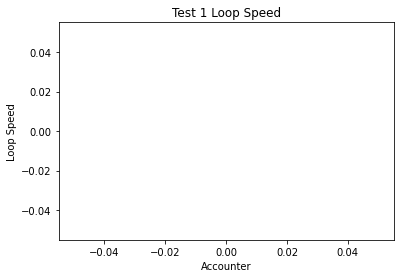

In [10]:
test_1_loop_speed = np.array(test1_df['LoopSpeedArr'])
test_1_x = np.arange(0, len(test_1_loop_speed))
plt.plot(test_1_x, test_1_loop_speed, color ="red")
plt.xlabel("Accounter")
plt.ylabel("Loop Speed")
plt.title("Test 1 Loop Speed")
plt.show()

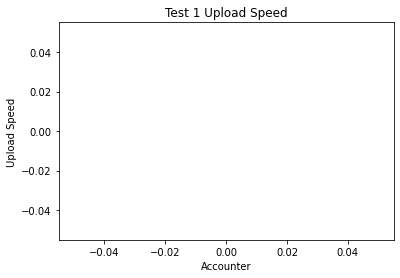

In [11]:
test_1_upload_speed = np.array(test1_df['UploadSpeedArr'])
test_1_x = np.arange(0, len(test_1_upload_speed))
plt.plot(test_1_x, test_1_upload_speed, color ="blue")
plt.xlabel("Accounter")
plt.ylabel("Upload Speed")
plt.title("Test 1 Upload Speed")
plt.show()

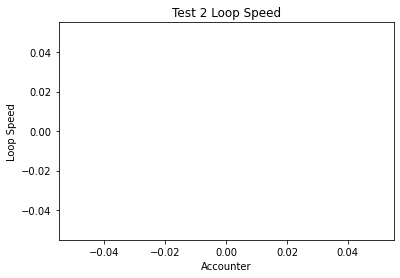

In [13]:
test_2_loop_speed = np.array(test2_df['LoopSpeedArr'])
test_2_x = np.arange(0, len(test_2_loop_speed))
plt.plot(test_2_x, test_2_loop_speed, color ="red")
plt.xlabel("Accounter")
plt.ylabel("Loop Speed")
plt.title("Test 2 Loop Speed")
plt.show()

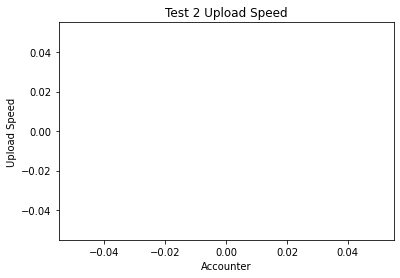

In [14]:
test_2_upload_speed = np.array(test2_df['UploadSpeedArr'])
test_2_x = np.arange(0, len(test_2_upload_speed))
plt.plot(test_2_x, test_2_upload_speed, color ="blue")
plt.xlabel("Accounter")
plt.ylabel("Upload Speed")
plt.title("Test 2 Upload Speed")
plt.show()

In [12]:
np.savetxt("test_1_loop_speed.txt", test_1_loop_speed)
np.savetxt("test_1_upload_speed.txt", test_1_upload_speed)

In [55]:
np.savetxt("test_2_loop_speed.txt", test_2_loop_speed)
np.savetxt("test_2_upload_speed.txt", test_2_upload_speed)

In [18]:
all_data = []

In [51]:
trial_data_1 = []
curr_accounter = ref_users_data.get()['Accounter']
curr_time = time.time()
while True:
    new_accounter = ref_users_data.get()['Accounter']
    if new_accounter != curr_accounter:
        trial_data_1.append(ref_users_data.get())

KeyboardInterrupt: 

In [43]:
ref_users_data.get()


{'Accounter': 39,
 'Datapoints': ['Set: 0 Ax: 0.15 Ay: 0.46 Az: 9.51 gx: -0.01 gy: -0.01 gz: -0.00 temp: 29.80 timing for this set: 3.00 Set: 1 Ax: 0.12 Ay: 0.43 Az: 9.50 gx: -0.01 gy: -0.01 gz: -0.00 temp: 29.75 timing for this set: 3.00 Set: 2 Ax: 0.17 Ay: 0.43 Az: 9.38 gx: -0.01 gy: -0.01 gz: -0.01 temp: 29.80 timing for this set: 3.00 Set: 3 Ax: 0.24 Ay: 0.43 Az: 9.42 gx: -0.01 gy: -0.02 gz: 0.00 temp: 29.71 timing for this set: 3.00 Set: 4 Ax: 0.20 Ay: 0.51 Az: 9.37 gx: -0.01 gy: -0.01 gz: -0.00 temp: 29.85 timing for this set: 3.00 Set: 5 Ax: 0.16 Ay: 0.45 Az: 9.42 gx: -0.01 gy: -0.02 gz: -0.01 temp: 29.66 timing for this set: 3.00 Set: 6 Ax: 0.12 Ay: 0.46 Az: 9.45 gx: -0.01 gy: -0.02 gz: -0.00 temp: 29.80 timing for this set: 3.00 Set: 7 Ax: 0.17 Ay: 0.53 Az: 9.50 gx: -0.01 gy: -0.01 gz: 0.00 temp: 29.71 timing for this set: 3.00 Set: 8 Ax: 0.14 Ay: 0.43 Az: 9.43 gx: -0.01 gy: -0.01 gz: -0.00 temp: 29.66 timing for this set: 3.00 Set: 9 Ax: 0.18 Ay: 0.46 Az: 9.44 gx: -0.01 gy: -

In [52]:
trial_data_1

[{'Accounter': 812,
  'Datapoints': ['Set: 0 Ax: 0.65 Ay: 9.38 Az: -4.97 gx: -0.63 gy: 2.92 gz: -1.13 temp: 31.07 timing for this set: 4.00 Set: 1 Ax: 0.57 Ay: 9.32 Az: -4.82 gx: -0.65 gy: 2.95 gz: -1.13 temp: 31.12 timing for this set: 3.00 Set: 2 Ax: 0.53 Ay: 9.14 Az: -4.65 gx: -0.68 gy: 2.98 gz: -1.13 temp: 31.07 timing for this set: 3.00 Set: 3 Ax: 0.33 Ay: 9.16 Az: -4.83 gx: -0.71 gy: 3.01 gz: -1.13 temp: 31.17 timing for this set: 2.00 Set: 4 Ax: 0.62 Ay: 9.02 Az: -4.37 gx: -0.73 gy: 3.01 gz: -1.15 temp: 31.12 timing for this set: 3.00 Set: 5 Ax: 0.30 Ay: 8.99 Az: -4.36 gx: -0.74 gy: 3.04 gz: -1.15 temp: 31.12 timing for this set: 3.00 Set: 6 Ax: 0.49 Ay: 8.94 Az: -4.25 gx: -0.75 gy: 3.05 gz: -1.16 temp: 31.02 timing for this set: 3.00 Set: 7 Ax: 0.30 Ay: 8.93 Az: -4.09 gx: -0.76 gy: 3.07 gz: -1.16 temp: 31.07 timing for this set: 3.00 Set: 8 Ax: 0.35 Ay: 8.92 Az: -4.05 gx: -0.76 gy: 3.09 gz: -1.15 temp: 31.17 timing for this set: 3.00 Set: 9 Ax: 0.30 Ay: 8.86 Az: -3.99 gx: -0.76

In [53]:
import pickle
with open("trial_data_5", "wb") as fp:   #Pickling
    pickle.dump(trial_data_1, fp)

with open("trial_data_5", "rb") as fp:   # Unpickling
    test = pickle.load(fp)

In [54]:
test

[{'Accounter': 812,
  'Datapoints': ['Set: 0 Ax: 0.65 Ay: 9.38 Az: -4.97 gx: -0.63 gy: 2.92 gz: -1.13 temp: 31.07 timing for this set: 4.00 Set: 1 Ax: 0.57 Ay: 9.32 Az: -4.82 gx: -0.65 gy: 2.95 gz: -1.13 temp: 31.12 timing for this set: 3.00 Set: 2 Ax: 0.53 Ay: 9.14 Az: -4.65 gx: -0.68 gy: 2.98 gz: -1.13 temp: 31.07 timing for this set: 3.00 Set: 3 Ax: 0.33 Ay: 9.16 Az: -4.83 gx: -0.71 gy: 3.01 gz: -1.13 temp: 31.17 timing for this set: 2.00 Set: 4 Ax: 0.62 Ay: 9.02 Az: -4.37 gx: -0.73 gy: 3.01 gz: -1.15 temp: 31.12 timing for this set: 3.00 Set: 5 Ax: 0.30 Ay: 8.99 Az: -4.36 gx: -0.74 gy: 3.04 gz: -1.15 temp: 31.12 timing for this set: 3.00 Set: 6 Ax: 0.49 Ay: 8.94 Az: -4.25 gx: -0.75 gy: 3.05 gz: -1.16 temp: 31.02 timing for this set: 3.00 Set: 7 Ax: 0.30 Ay: 8.93 Az: -4.09 gx: -0.76 gy: 3.07 gz: -1.16 temp: 31.07 timing for this set: 3.00 Set: 8 Ax: 0.35 Ay: 8.92 Az: -4.05 gx: -0.76 gy: 3.09 gz: -1.15 temp: 31.17 timing for this set: 3.00 Set: 9 Ax: 0.30 Ay: 8.86 Az: -3.99 gx: -0.76